# Part 2: Sentiment analysis


_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).
>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 
>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.
>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?
>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 
>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).
>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 
>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 
>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

In [300]:
import nltk, re, pprint
from nltk import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.dates as mdate
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.pyplot as plt
import re
import datetime as datetime
from collections import Counter

data = pd.read_csv("wallstreet_subs.csv", parse_dates = True)

Combining titles and main text

In [302]:
empty = []
for i in range(len(data['title'])):
    empty.append(data['title'][i]+' '+data['selftext'][i])
data['text'] = empty

>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).


## Our answer:

We picked Christmas day (25th of December), since it seems reasonable to assume that this will be a day with relatively positive sentiment. 

>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively.

Some preprocessing: converting utc to datetime

In [ ]:
data['date'] = [datetime.datetime.fromtimestamp(ts) for ts in data['created_utc']]
data['date'] = data['date'].dt.date
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True)

Defining datetime ranges

In [780]:
d = data.loc['2020-12-25'].index[0]
d_min = d - datetime.timedelta(days=7)

Defining preprocessing functions

In [762]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            continue
        else:
            new_words.append(word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    sample = replace_contractions(sample)
    # Tokenize
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

Extracting tokens and preprocessing text for all submissions

In [763]:
data['tokens'] = [preprocess(data['text'][i]) for i in range(len(data['text']))]

#^takes a long time to run

Building the two lists $l$ and $l_{ref}$

In [781]:
l = np.ndarray.tolist(np.concatenate(data.loc[d]['tokens']))

In [782]:
l_ref = []
date = d_min
while date <= d:
    l_ref.append(np.concatenate(data.loc[date]['tokens']))
    date += datetime.timedelta(days=1)
l_ref = [item for sublist in l_ref for item in sublist]
    

>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

Computing the relative frequencies of $l$ and $l_{ref}$ and storing them in $\textit{two}$ dictiobaries for ease of use

In [784]:
p = dict([(item[0],item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0],item[1]/len(l_ref)) for item in Counter(l_ref).items()])

Displaying top 10 words with highest relative frequency in each list (not asked for directly)

In [785]:
sorted(p.items(), key = lambda x:x[1],reverse=True)[:10]

[('like', 0.007071765322158198),
 ('gme', 0.0054129561725161516),
 ('get', 0.005238344683080147),
 ('money', 0.005151038938362144),
 ('stock', 0.004539898725336127),
 ('year', 0.004365287235900122),
 ('shares', 0.004365287235900122),
 ('make', 0.004277981491182119),
 ('market', 0.004103370001746115),
 ('going', 0.00392875851231011)]

In [786]:
sorted(p_ref.items(), key = lambda x:x[1],reverse=True)[:10]

[('market', 0.005810589655001405),
 ('stock', 0.0055791579190980775),
 ('amp', 0.005273337410940109),
 ('like', 0.005182417800406658),
 ('going', 0.00469475807118179),
 ('company', 0.00460383846064834),
 ('shares', 0.0042070983419569205),
 ('would', 0.004182302084538707),
 ('get', 0.004182302084538707),
 ('price', 0.004050055378308234)]

>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency).

Computing the difference in relative frequency by first taking the set of all tokens and then subtracting the two lists.

In [770]:
all_tokens = set(p.keys()).union(set(p_ref.keys()))

In [771]:
dp = dict([(token, p.get(token,0) - p_ref.get(token,0)) for token in all_tokens])

In [787]:
sorted(dp.items(), key = lambda x:x[1], reverse = True)[:10]

[('christmas', 0.0027457658878667487),
 ('gme', 0.002272096899542419),
 ('cerner', 0.001976008139464947),
 ('like', 0.00188934752175154),
 ('merry', 0.0017068631736800446),
 ('money', 0.0015638470318605656),
 ('make', 0.0014760044029239736),
 ('robinhood', 0.0011143291739498548),
 ('margin', 0.0010766159440682797),
 ('get', 0.0010560425985414396)]

## Question:

Do you notice anything interesting?

## Our answer:

Unsurprisingly ‘Christmas’ and ‘Merry’ are among the words with the largest relative frequency. However, it is more interesting to see that ‘gme’ (referring to the GameStop stocks) is among the top 10. As we know, the GME stock rose exponentially in the month of January 2021 and seeing it high on this relative frequency list can in retrospect be seen as an early sign of this.

>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 

In [773]:
labMt_dict = pd.read_csv("Hedonometer.csv")
labMt_dict = labMt_dict.set_index("Word")

In [774]:
h = dict([(token, labMt_dict["Happiness Score"].get(token,np.nan)-5) for token in all_tokens])

In [775]:
dPhi = dict([(token,h[token]*dp[token]) for token in all_tokens if not np.isnan(h[token])])

>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. 

In [776]:
sorted(dPhi.items(), key = lambda x:np.abs(x[1]), reverse = True)[:10]

[('christmas', 0.008127467028085577),
 ('merry', 0.004369569724620914),
 ('like', 0.004194351498288418),
 ('money', 0.0035968481732793003),
 ('million', -0.0025671135942025463),
 ('market', -0.0021852411561667723),
 ('covid', 0.0017071916544546435),
 ('thanks', 0.0016242306308432003),
 ('first', 0.001588118759170167),
 ('rich', 0.001577980653238633)]

## Question:

 Explain in your own words the meaning of $\delta \Phi$

## Our answer:

$\delta p$ denotes the change in word occurrences from the prior 7 days compared to the chson day. 

$h(i)$ denotes the happiness of a given word. 

As such, $\delta  \Phi$ denotes the change in happiness a given word contributes for the final day compared to the prior 7 days - i.e. it denotes the change in impact of the words.

# Something about the last sentence sounds strange? ^change in impact?

>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 
>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. 

In [777]:
import shifterator as sh



In [778]:
sentiment_sh = sh.WeightedAvgShift(type2freq_1=p_ref,
                    type2freq_2=p,
                    type2score_1 = 'labMT_English',
                    reference_value=5)

C:\Users\rune7\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


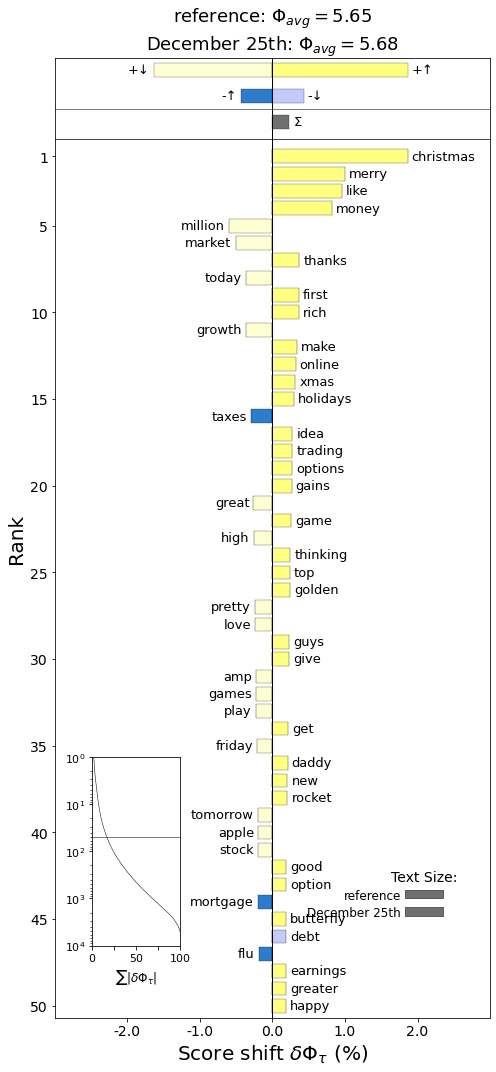

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.65\nDecember 25th: $\\Phi_{avg}=$5.68'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [779]:
sentiment_sh.get_shift_graph(detailed= True,
                            system_names = ['reference', 'December 25th'])

## Question:

Comment on the figure. 

## Our answer:

The figure shows that words like “christmas”, “merry”, “like” and “money” are positive words that unsurprisingly occurred more often and thereby contributed to December 25th being a date with more positive sentiment than the reference period of 7 days before this date. 

Interestingly we see that the word “market” is considered a positive word and that it occurred less often, which subtracts from the higher positive sentiment score of December 25th. This is interesting firstly partly because it is revealing of the values of the people whose scoring was used to make the sentiment lexicon (i.e. they are liberal). Secondly, it is interesting because it shows that users on wallstreetbets used the word “market” less on Christmas day. This indicates that they were less focused on the core topic of the subreddit (trading stocks) and instead spent more words on social conversations in wishing each other “Merry Christmas”.

There are only minor differences in negative words being used more (“flu”) or less (“debt”) often. As such, it is primarily the difference in usage of positive words that contributed to the 25th of December being a day with more positive sentiment.


>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

## Our answer:

They are basically identical but for the fact that “covid” does not appear in the WordShift but appears in exercise 6. The ordering of the two are also identical.

The great similarity makes sense, as the two methods are essentially the same. 
